In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
#build the vocab of chars and mappings to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
        

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revised
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  #hidden layer

g  = torch.Generator().manual_seed(2147729)
C  = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3)/((n_embd * block_size) ** 0.5) #* 0.3
b1 = torch.randn((n_hidden),                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn((vocab_size),                      generator=g) * 0 #to stabilize the logits

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [7]:
# Optimazation
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  #random indices
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass -----------
    emb = C[Xb]  #embed characters into vectors
    embcat = emb.view(emb.shape[0], -1)  #concatanate the vectors or flatten
    hpreact = embcat @ W1 # + b1  #hidden layer preactivation

    ## batch norm layer ---------------------
    bnmeani = hpreact.mean(0, keepdim=True)  #trucker
    bnstdi = hpreact.std(0, keepdim=True)   #trucker
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization one

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    ## non linearlity layer  --------------
    h = torch.tanh(hpreact)  #hidden layer
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb)  #loss function

    #backward pass ---------------
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        if p.grad is not None:
            p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f} :lr={lr}")
    lossi.append(loss.log10().item())

    # break





      0/ 200000: 3.3029 :lr=0.1
  10000/ 200000: 2.3750 :lr=0.1
  20000/ 200000: 1.9687 :lr=0.1
  30000/ 200000: 2.4177 :lr=0.1
  40000/ 200000: 2.1398 :lr=0.1
  50000/ 200000: 2.1092 :lr=0.1
  60000/ 200000: 2.3437 :lr=0.1
  70000/ 200000: 2.1463 :lr=0.1
  80000/ 200000: 1.9088 :lr=0.1
  90000/ 200000: 2.3998 :lr=0.1
 100000/ 200000: 2.0118 :lr=0.01
 110000/ 200000: 1.7893 :lr=0.01
 120000/ 200000: 2.0460 :lr=0.01
 130000/ 200000: 1.9203 :lr=0.01
 140000/ 200000: 2.1039 :lr=0.01
 150000/ 200000: 1.9127 :lr=0.01
 160000/ 200000: 2.0986 :lr=0.01
 170000/ 200000: 2.5403 :lr=0.01
 180000/ 200000: 1.9130 :lr=0.01
 190000/ 200000: 2.6459 :lr=0.01


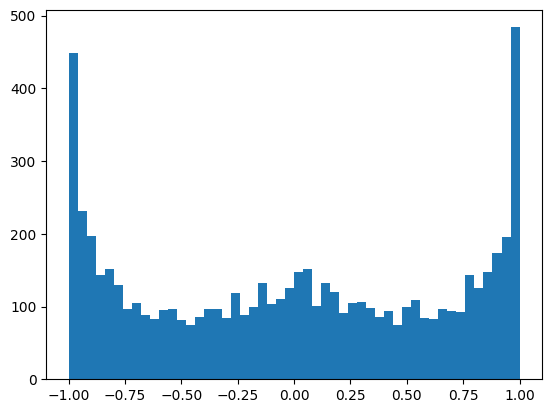

In [8]:
# print(h.shape)
# print(h)
# print(h.view(-1).shape)
plt.hist(h.view(-1).tolist(), 50);

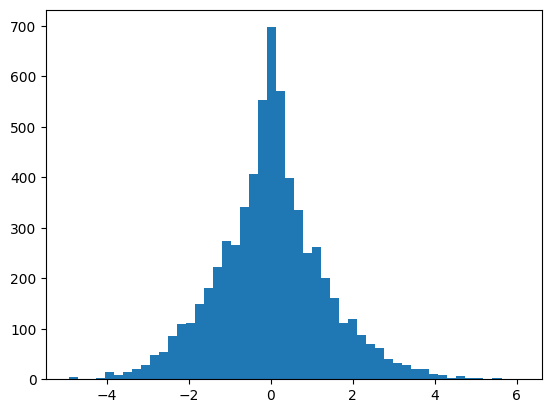

In [9]:
plt.hist(hpreact.view(-1).tolist(), 50);

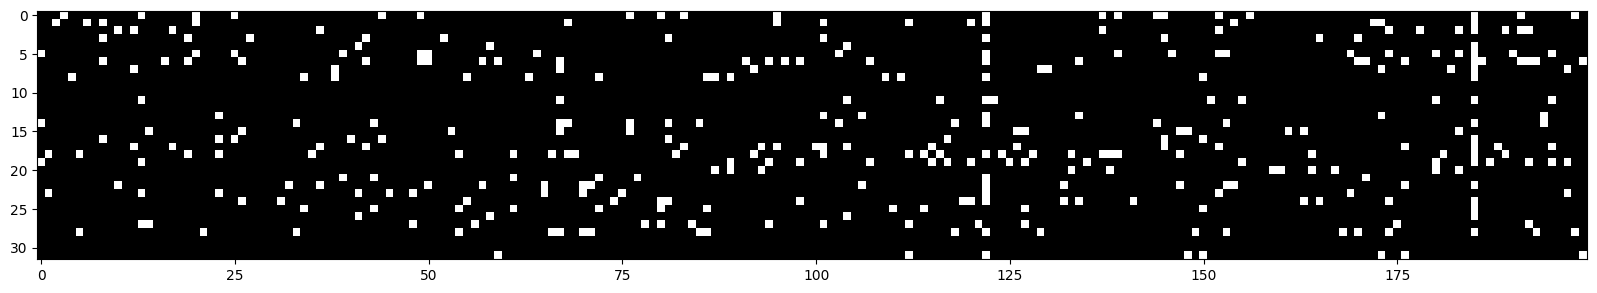

In [10]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# grayscale colomap white = true, balck = false
# white neurons are in flat tail portion.  no gradient expected.

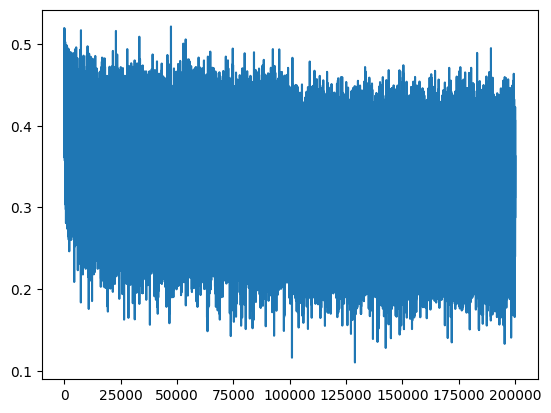

In [11]:
plt.plot(lossi)

In [12]:
# calibrate the batch norm at the end of training
# on hand calculation

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad()  #disable gradient tracking

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batch normalization one
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067244291305542
val 2.107518434524536


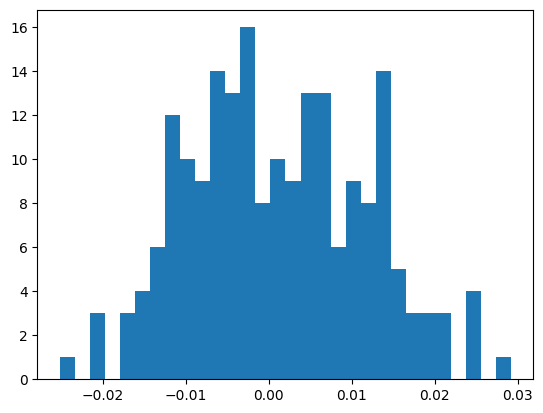

In [13]:
plt.hist(b1.view(-1).tolist(), 30);

In [14]:
@torch.no_grad()  #disable gradient tracking

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization one
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.865917444229126
val 2.920969009399414


In [15]:
# sample from the model

g = torch.Generator().manual_seed(2123123)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  #l, blocksize, n_embed
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

zikvorbyvlizahduntecxcyusrlin.
bbyazlahdamirthmechukwu.
ffon.
amellaniasildashdharifcenahlighyazahkaelawegjaneliahladdalimphizahkamiqunsmielissabellaiksiwarlowindin.
jakyirvathamirydhlfomcklyn.
chagabyaphnnickelbikaylianahlailandinahmwnylammyliah.
dawmbxxlynerliylahnamiah.
maxmarcavyarmandermoekshoxraevellasiylaazahliahmirajzzijah.
lorahmwelliamariffetheeliahanviklanyamiryahiriah.
evistinahmw.
lartidgeaglettisamaggermariffon.
kizlechartikahlakstargurmezahdamntleveongadaycerimarybystorvisvaurelissivaahbryadhavarajsaxliajabbamaryamagibnairk.
litqetchrstinder.
kindommuellahnahmaryiavarxelyj.
melahnaylindyanvishawn.
hvurcidgjourwahlashlilanyixxamayvlynekianailykinleithonahmandhawn.
kelahmodlizahridydrithy.
tevonth.
dajeliyahbahzaricklardohdemarliepaathriyahmowrysthallridgidannahmaxmajaarligracelahjashleezaldillynehladeivellizaivenaidezahkamiahnakirvinahmikahlizahniveggynzixmandrithmnddislehdanardisheamianahliliahaqub.
jalissabbiggianayylda.


In [16]:
# 4 dimensional exmaple of the issue
# all of the logis are stable or all zeros is better
logits = torch.tensor([-5.0, 5.0, 0.0, 2.0])
logits = torch.randn(4) *10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([  0.7116, -14.1046,  11.2176,  -8.2409]),
 tensor([2.7372e-05, 1.0063e-11, 9.9997e-01, 3.5421e-09]),
 tensor(2.7419e-05))

#### Xavier (Glorot) Initialization — Explained Simply
Xavier (also called Glorot) initialization is a method for initializing the weights of a neural network so that the variance of the activations stays the same across every layer during the forward and backward passes.

tensor(-0.0089) tensor(1.0037)
tensor(0.0003) tensor(1.0066)


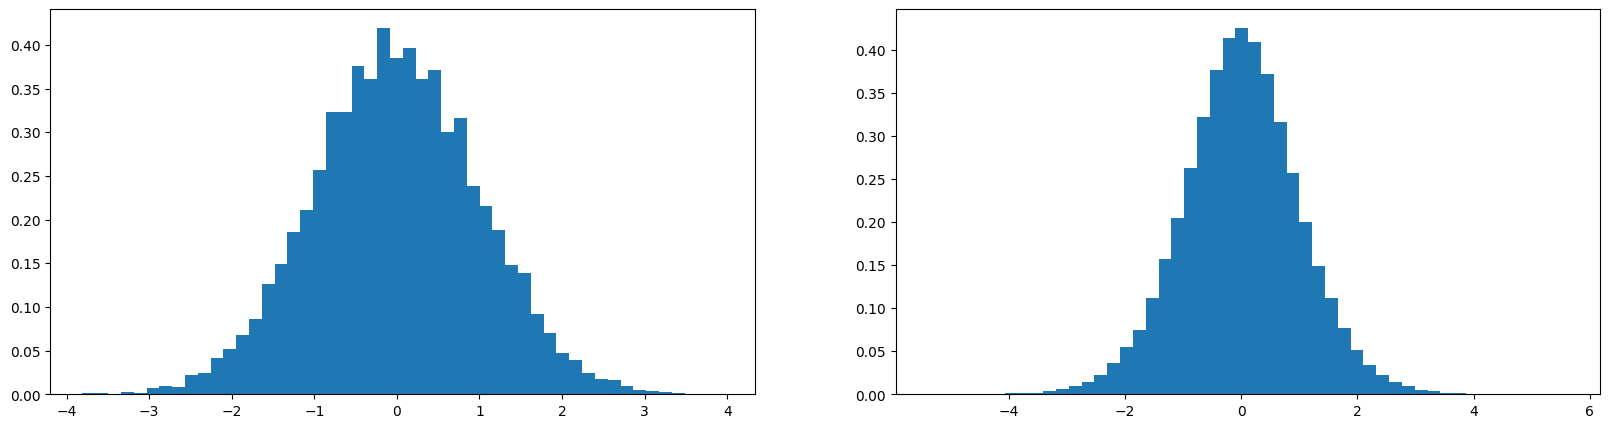

In [17]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 **0.5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density= True);

# how to preserve the gaussian?

In [18]:
# Batch Normalization
hpreact.mean(0, keepdim=True).shape
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])